# 1.2 Time-series data analysis

**This notebook is inspried by [CMI-PIU: Actigraphy data EDA](https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda) for exploratory time-series data analysis.**

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

**Time-series data is composed of a continuous series of data points measured over time. In this analysis, we will select a particular participant to examine the relevant information fields. This will provide us with a foundation for processing the time-series data effectively.**

In [2]:
path = '../data/series_train.parquet/id=0417c91e/part-0.parquet'
series_train = pd.read_parquet(path, )

series_train

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.014375,-0.020112,-0.995358,0.001060,-88.445251,0.0,41.000000,4195.000000,44100000000000,2,2,5.0
1,1,0.014167,-0.023278,-0.996164,0.000289,-88.372200,0.0,41.000000,4194.833496,44105000000000,2,2,5.0
2,2,0.014036,-0.022964,-0.996320,0.000301,-88.356422,0.0,41.500000,4194.666504,44110000000000,2,2,5.0
3,3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.500000,4194.500000,44115000000000,2,2,5.0
4,4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.000000,44780000000000,2,2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287174,287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.000000,3695.000000,32875000000000,1,3,53.0
287175,287175,-0.703572,0.016187,0.159560,0.035980,14.121390,0.0,7.000000,3695.000000,32880000000000,1,3,53.0
287176,287176,-0.209607,-0.469700,0.636573,0.097799,44.998573,0.0,7.000000,3695.000000,32885000000000,1,3,53.0
287177,287177,-0.390378,0.284386,0.147654,0.057826,7.726313,0.0,7.000000,3695.000000,32890000000000,1,3,53.0


The columns are:
* step: Correspond to each observation
* X, Y, Z: measure of acceleration -> Describe the motivation
* enmo: calculated & described by Wrispy package, = max(0, value) -> 0: no motion
* angleZ: the angle of the arm relative to the horizotal plane -> How arm is positioned during the activity
* non-wear_flag: 0 (being worn), 1 (not worn)
* light: ambuient light -> Distinguish time (day/ night?), type of act (outdoor/ indoor)
* battery_voltage: Not important for modeling, but may be effective in identifying isssues related to data collecting process
* time_of_day: nanoseconds
* weekday: identify behaviour patterns during week days vs. weekends
* quarter: may result in seasonal behaviours
* relative_data_PCIAT: The number of days (integer) since the PCIAT test was administered

**It is completely noteworthy to consider a feature called "non-wear_flag," which has binary values: 0 indicating that a measuring device is not being worn, and 1 indicating that it is being worn. We observed that many public notebooks with high scores (such as 0.497, 0.494, 0.489, etc.) analyze time-series data superficially, just calculate basic statistics like mean, maximum, minimum, and standard deviation for all columns in the time-series data, without considering feature implication. This approach leads to a discrepancy between their high public scores and lower scores on the hidden test set.**

**It is crucial to filter out rows where non-wear_flag equals 0. If a participant does not wear the device, the other metrics become random and meaningless, which is a common issue in most notebooks.**

**Implement a helper function for plotting time-series data of the participant**

In [3]:
def plot_series_data(df, col='non-wear_flag',
                     label='Worn (0 = Worn, 1 = Not Worn)',
                     title='Non-Wear Flag',
                     x_col='day_time', x_label='Day Relative to PCIAT + Time'):
    plt.figure(figsize=(18, 12))
    
    
    # ENMO
    plt.subplot(4, 1, 1)
    plt.scatter(df[x_col], df['enmo'], label='ENMO', color='green', s=1)
    plt.title('ENMO (Euclidean Norm Minus One)')
    plt.ylabel('Movement Intensity')
    
    #x_col = step, x_label = step

    # Angle Z
    plt.subplot(4, 1, 2)
    plt.scatter(df[x_col], df['anglez'], label='Angle Z', color='blue', s=1)
    plt.title('Angle Z')
    plt.ylabel('Angle (degrees)')

    # Light
    plt.subplot(4, 1, 3)
    plt.scatter(df[x_col], df['light'], label='Light', color='orange', s=1)
    plt.title('Ambient Light')
    plt.ylabel('Light (lux)')

    # Any other column
    plt.subplot(4, 1, 4)
    plt.scatter(df[x_col], df[col], label=col, color='red', s=1)
    plt.title(f'{title}')
    plt.ylabel(f'{label}')
    plt.xlabel(f'{x_label}')

    plt.tight_layout()
    plt.show()

**The plot below shows that the participant always worns device during the experiment time**

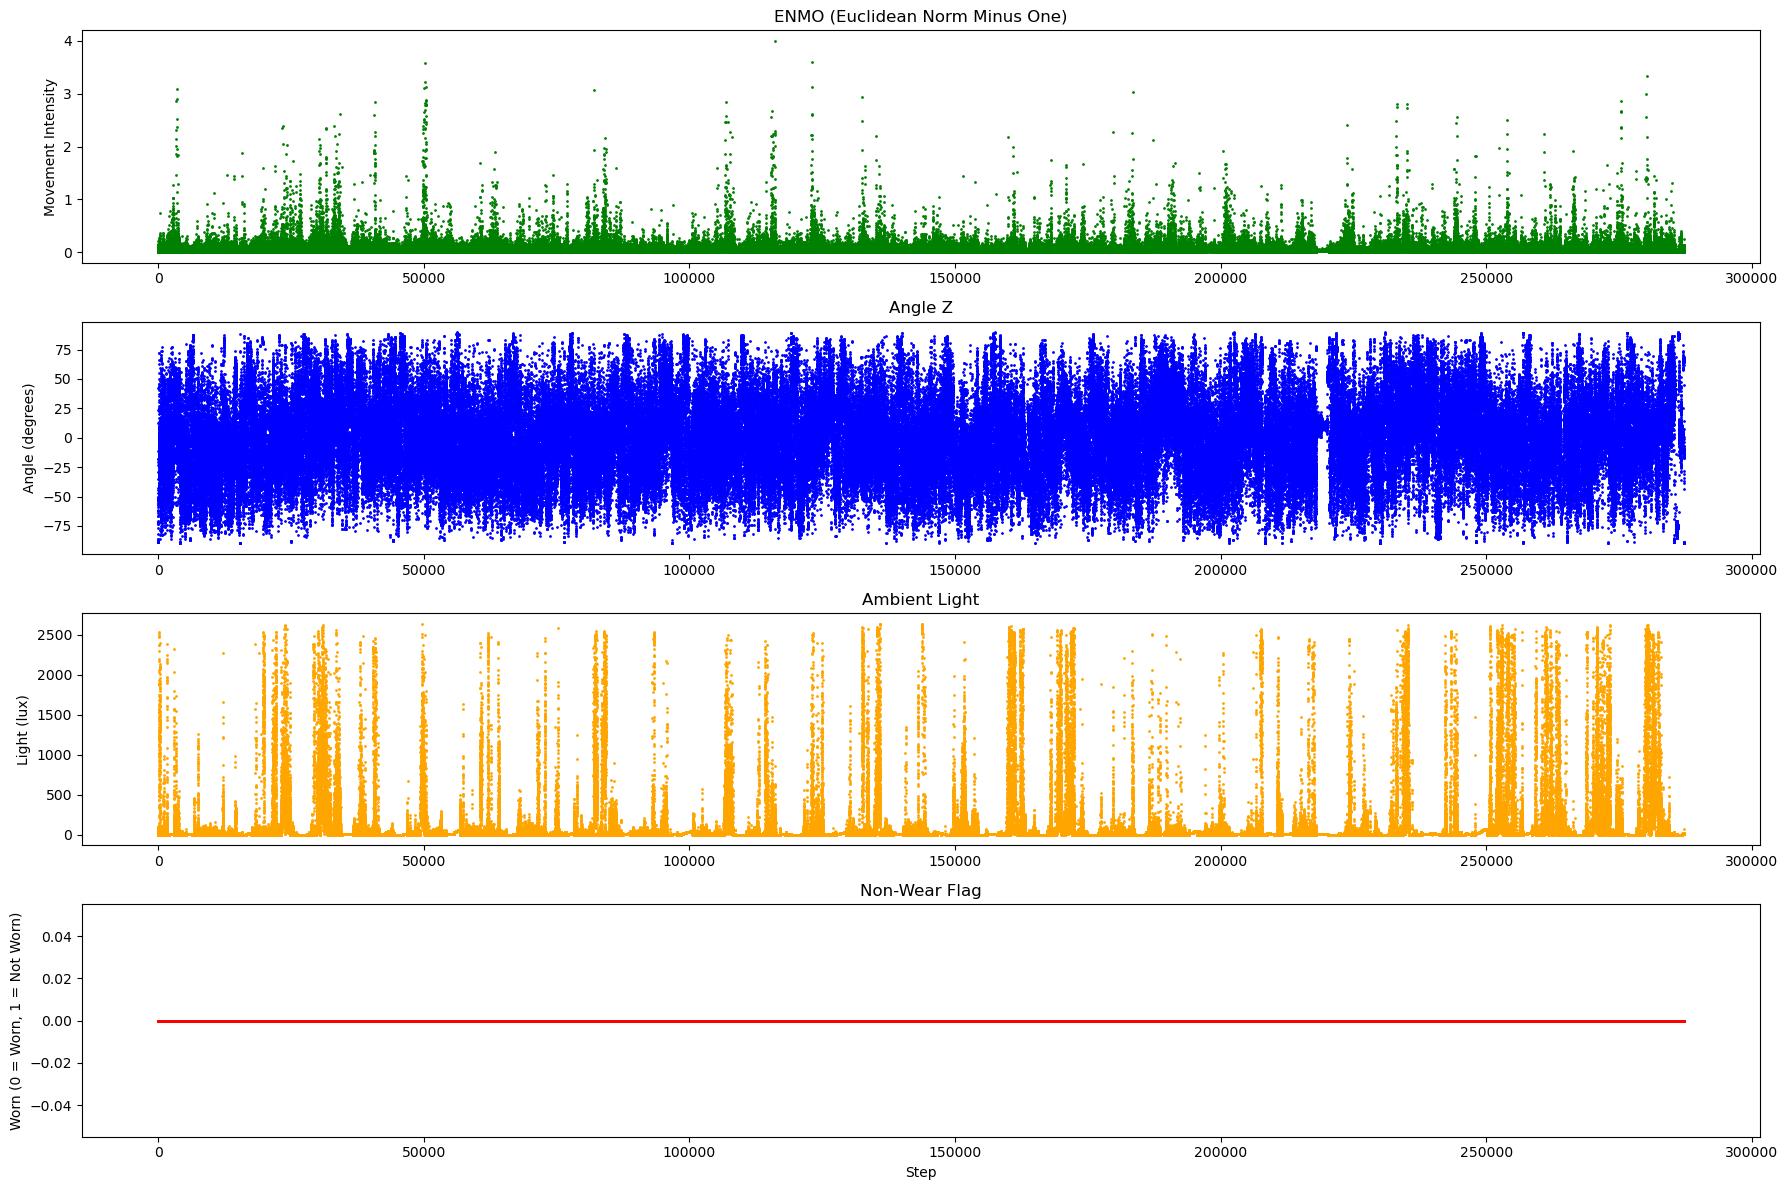

In [4]:
plot_series_data(series_train, x_col='step', x_label='Step')

**However, if we take time-series data from another participant, the shown plot might change significantly.**

**If the pevious participant consistently worn the device, the next one worn it very rarely. Therefore, failing to consider the factor of device usage can introduce data noise, which directly impacts model performance. We believe that analyzing the data in a clear and detailed manner is a key factor contributing to the our final score of rank 96. If the quality of the data is insufficient, the model will not be able to achieve the desired results.**

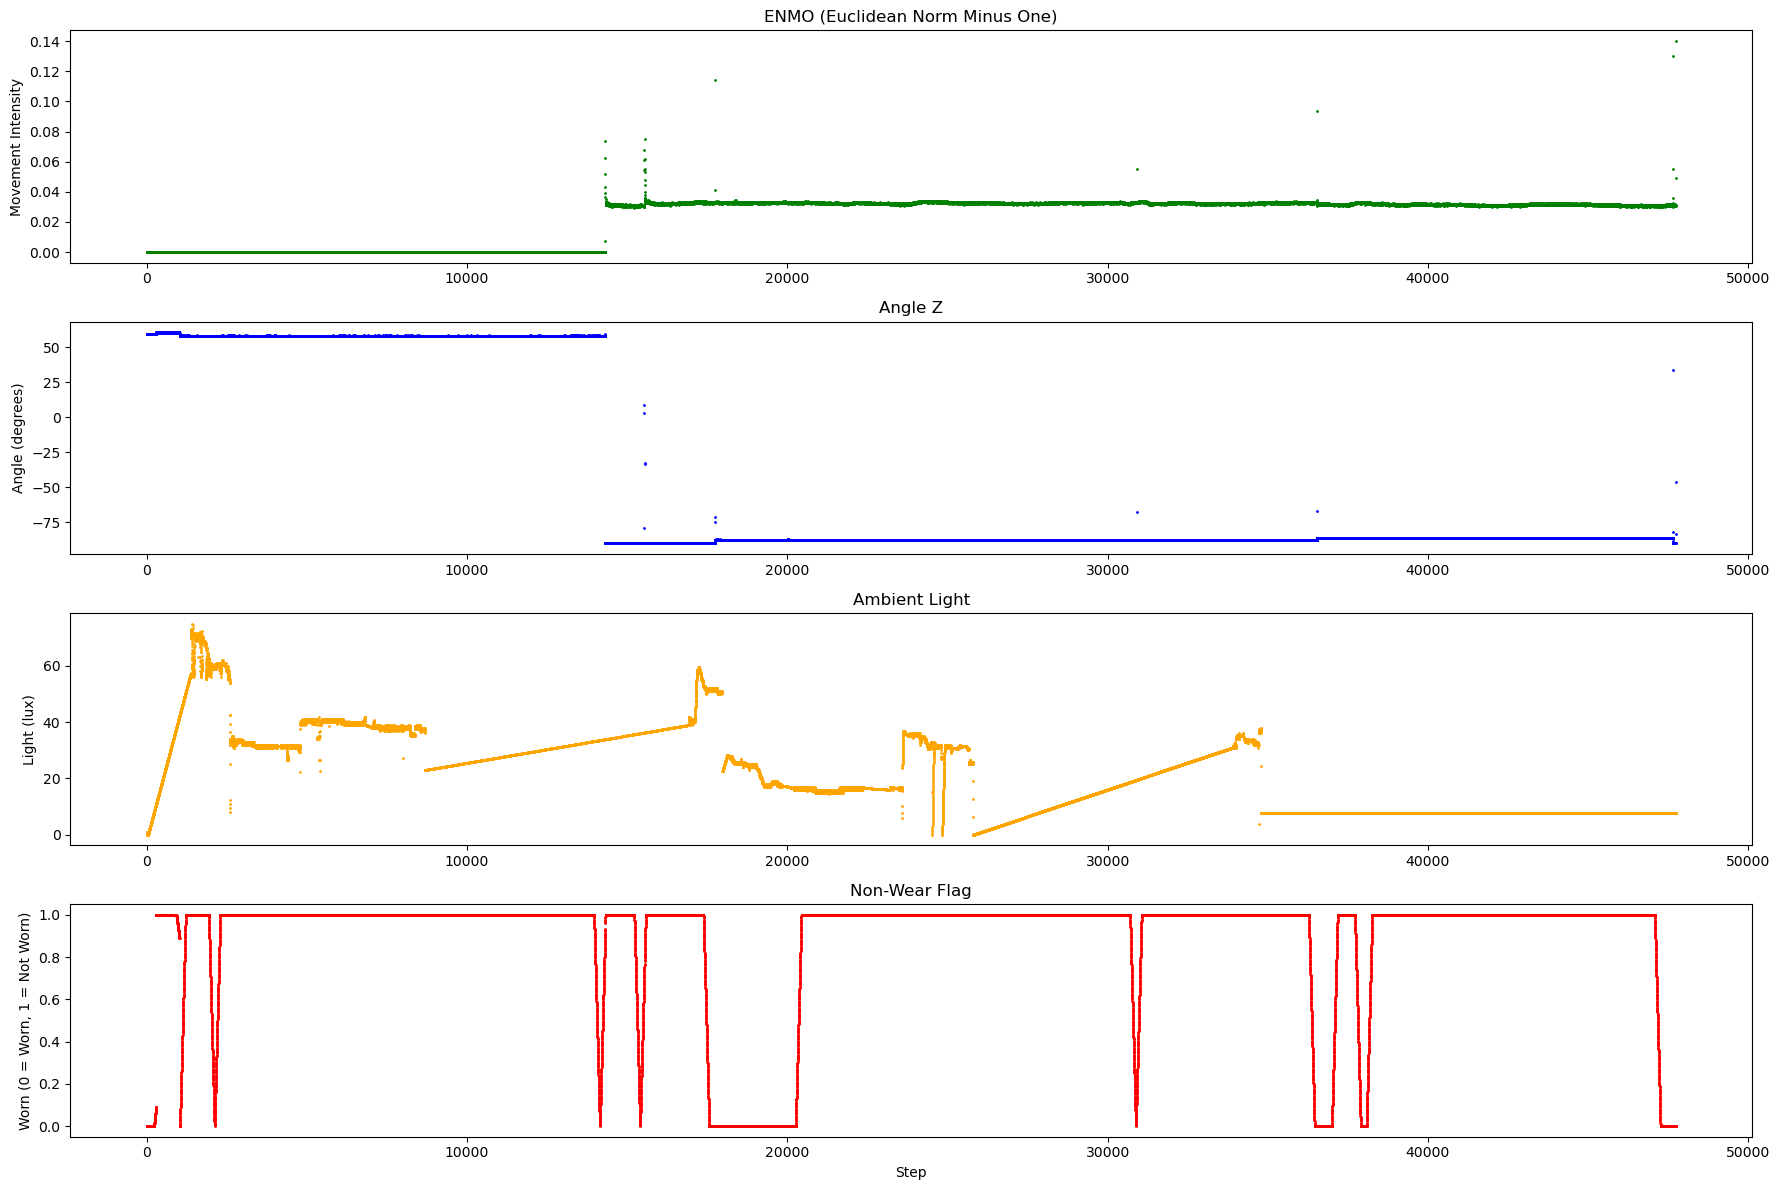

In [5]:
path = '../data/series_train.parquet/id=4950e24c/part-0.parquet'
series_train = pd.read_parquet(path, )
plot_series_data(series_train, x_col='step', x_label='Step')

**Additionally, there are specific analyses from a scientific perspective related to the measured indicators throughout the experimental period. This includes an evaluation of active, weak, or inactive activities, as well as the correlation between light index and living habits, circadian rhytham analysis, physical activity analysis, and activity transition analysis(see details in the notebook [CMI-PIU: Actigraphy data EDA](https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda)). All the scientific perspectives outlined in this notebook have been carefully considered and serve as the foundation for our feature engineering technique applied on the dataset. More specifically about time-series feature engineering, please refer to section 1.3 Data loading & Processing.**